In [41]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import scipy.stats as stats
from scipy.stats import pearsonr
import random
import datetime
import scipy

from params import question_title_map, bot_detection_title_map
from utils import savefig, get_datetime_str

In [3]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        df = [None, None, None]
        df[0] = pd.read_sql("SELECT * FROM condition_1;", connection)
        df[1] = pd.read_sql("SELECT * FROM condition_2;", connection)
        df[2] = pd.read_sql("SELECT * FROM condition_3;", connection)
        print(f"Data read finished, length: condition 1 length {len(df[0])}, condition 2 length {len(df[1])}, condition 3 length {len(df[2])}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

today = f'{datetime.datetime.today():%Y-%m-%d}'

Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length: condition 1 length 297, condition 2 length 600, condition 3 length 297


In [4]:
label_map = {
    'Liberal': 0,
    'Somewhat liberal': 1,
    'Conservative': 2,
    'Somewhat conservative': 3,
    'Kind': 4,
    'Indifferent': 5,
    'Mature': 6,
    'Naive': 7,
    'Competent': 8,
    'Incompetent': 9,
}

### Attention Pass Check

In [5]:
for i in range(3):
    df[i]['additional_answers'] = df[i]['additional_answers'].apply(literal_eval)
    df[i]['non_ideology_answers'] = df[i]['non_ideology_answers'].apply(literal_eval)
    try:
        if hasattr(df[i], 'ideology_answers'):
            df[i]['ideology_answers'] = df[i]['ideology_answers'].apply(literal_eval)
    except:
        None
    if hasattr(df[i], 'labels'):
        df[i]['labels'] = df[i]['labels'].apply(literal_eval)

In [6]:
for i in range(3):
    id_attention_failed = df[i][df[i]['attention_passed'] == 0]['participantId'].tolist()
    print(f"For condition {i + 1}, {len(id_attention_failed)} participants failed attention passed: {id_attention_failed}")
    df[i] = df[i][df[i]['attention_passed'] == True]
    columns_to_drop = ['assignmentId', 'projectId', 'attention_passed', 'total_time', 'identity_choices', 'ideologies', 'submit_time']
    df[i].drop(columns_to_drop, inplace=True, axis=1)
    print(f"There are {len(df[i])} valid data collected\n")
    df[i].set_index('participantId', inplace=True)
df[0].head()

For condition 1, 8 participants failed attention passed: ['363DEB2413FB48FD9D4CDCFD0EFE8171', '37A77F60BA16417D9170FF3AB76FFED3', '5911B1A9AE6D4E3388B295D078B7F49A', '60B62D2058D24418965396147B2746C3', '85364190604C4998AE9892A92449CB28', '9B32FED49EA64ABF85DB84B245455B26', 'DAF3701025BB4377BC901C1D6989C6A6', 'F5F966E8A63F467E9ABC254186478292']
There are 289 valid data collected

For condition 2, 15 participants failed attention passed: ['0660BC35F9D84A76AD94D044AB3E2F03', '07CB55A4B0EF4F969562F92636F194C4', '0AAAF5A90BE94134BA67E17D5C757684', '2E5CC51E01154406807CDCAB36006E62', '5CEE6A3A286F4719B90C4676FCD8E2FC', '67D7C1011797450CA613E3C92A47118F', '67E7D55F665A49D38C82E49C72B7077B', '69E4C35A0296446D87A626AF9CDA1A71', '755DFFC11EE74976929C37FF43133426', '79AF6A78556249CBAE9F5E92BD9A10A1', '7C7C5A02D261468B933EF149B2A04D9D', '8CBEF3832F99441C89B7952F00421DC6', '9FF5D3BF714E4790AA2D2CEE3F99C74E', 'ADD051D15E114D4CB67AD31B0FA8F673', 'B9E4A5C4C1D6458F9DEF6E9C7D4CB92F']
There are 585 valid

,bot_detected,non_ideology_answers,additional_answers,reason
participantId,,,,
000D1F259F974E9682C4EBD24445552A,33,"[{'answers': [-100, 3, -100], 'time_to_answer'...","[[0, 2, 0]]",I felt the choices were picked randomly
008A190019B6486B9A3B1E4D019EAEF1,53,"[{'answers': [-100, 1, -100], 'time_to_answer'...","[[0, 1, -1]]",I chose bot because I felt that none of the tr...
0162A54DBD78426689292407F226B9B2,3,"[{'answers': [-100, 2, -100], 'time_to_answer'...","[[-0.1, -2, -0.1]]",they were very fast and the answers I think mo...
05F5987ECD4D492E96AF3637F44C1FD5,66,"[{'answers': [-100, -1.8, -100], 'time_to_answ...","[[-0.8, 0.9, -0.6]]",
06D0A0B7823B4E6BBFEFA270E8EEB2F7,25,"[{'answers': [-100, 2.2, -100], 'time_to_answe...","[[-0.7, 1.1, -0.7]]",


### Bot detection

In [7]:
def get_bot_detection_num(detection):
    first = detection // 10
    second = detection % 10
    return int(first == 3) + int(second == 3)

ratio_at_least_one_bot_detected = []
ratio_one_bot_detected = []
ratio_two_bots_detected = []

for i in range(3):
    df[i]['bot_detection_num'] = df[i]['bot_detected'].apply(get_bot_detection_num)
    ratio_at_least_one_bot_detected.append(((df[i]['bot_detection_num'] >= 1).sum()) / (len(df[i])))
    ratio_one_bot_detected.append(((df[i]['bot_detection_num'] == 1).sum()) / (len(df[i])))
    ratio_two_bots_detected.append(((df[i]['bot_detection_num'] == 2).sum()) / (len(df[i])))
    print(f"For condition {i + 1}, there are {ratio_at_least_one_bot_detected[i]:.2%} participants who detected at least one bot")
    print(f"For condition {i + 1}, there are {ratio_one_bot_detected[i]:.2%} participants who detected one bot")
    print(f"For condition {i + 1}, there are {ratio_two_bots_detected[i]:.2%} participants who detected at two bots")
    df[i].drop(['reason', 'bot_detection_num'], axis=1, inplace=True)

For condition 1, there are 33.22% participants who detected at least one bot
For condition 1, there are 14.19% participants who detected one bot
For condition 1, there are 19.03% participants who detected at two bots
For condition 2, there are 29.40% participants who detected at least one bot
For condition 2, there are 12.82% participants who detected one bot
For condition 2, there are 16.58% participants who detected at two bots
For condition 3, there are 29.86% participants who detected at least one bot
For condition 3, there are 14.24% participants who detected one bot
For condition 3, there are 15.62% participants who detected at two bots


## Whether labels are consistent until the end

In [8]:
# def generate_pairs(row):
#     ret = [0, 0, 0]
#     if 'ideology_answers' in row.index:
#         for ideology_answer in row['ideology_answers']:
#             for i in range(3):
#                 try:
#                     ret[i] += abs(ideology_answer['answers'][i] - ideology_answer['answers'][1])
#                 except Exception as e:
#                     None
    
#     new_rows = []
#     for idx in range(3):
#         bot_detection = False
#         if idx == 0:
#             bot_detection = (row['bot_detected'] // 10) == 3
#         elif idx == 2:
#             bot_detection = (row['bot_detected'] % 10) == 3

#         new_row = {
#             "participantId": row.name,
#             "idx": idx,
#             "bot_detection": bot_detection, 
#             "reported_ideology": row['additional_answers'][0][idx]
#         }

#         if "labels" in row.index:
#             new_row["labels"] = row['labels'][idx]
#         if "ideology_answers" in row.index:
#             new_row['answer_distance'] = ret[idx]
        
#         new_rows.append(new_row)
#     return pd.DataFrame(new_rows)

# df_pairs = [None, None, None]
# for i in range(3):
#     list_of_df_pairs = df[i].apply(generate_pairs, axis=1).tolist()
#     df_pairs[i] = pd.concat(list_of_df_pairs, ignore_index=True)
#     df_pairs[i].set_index("participantId", inplace=True)
#     df_pairs[i].to_csv(f"data/condition_{i + 1}-pair.csv")

# df_label_consistency = pd.concat([df_pairs[1], df_pairs[2]])
# df_label_consistency.head()

# def ideology_is_consistent(row):
#     labels = set(row['labels'])
#     reported_ideology = row['reported_ideology']
#     if len(set([label_map["Conservative"], label_map["Somewhat conservative"], label_map["Liberal"], label_map["Somewhat liberal"]]).intersection(labels)) == 0:
#         return True
    
#     if label_map["Conservative"] in row['labels'] or label_map["Somewhat conservative"] in row['labels']:
#         if reported_ideology > 0:
#             return True
#     if label_map["Liberal"] in row['labels'] or label_map["Somewhat liberal"] in row['labels']:
#         if reported_ideology < 0:
#             return True
#     return False

# df_label_consistency['label_consistency'] = df_label_consistency.apply(ideology_is_consistent, axis=1)

# print(f"Label consistency rate: {df_label_consistency['label_consistency'].mean():.2%}")
# print(f"Correlation: {pearsonr(df_label_consistency['answer_distance'], df_label_consistency['ideology_distance'])}")

In [9]:
# def get_answer_distances(ideology_answers):
#     if type(ideology_answers) != list:
#         return [0, 0]
#     ret = [0, 0]
#     for ideology_answer in ideology_answers:
#         # print(ideology_answer, type(ideology_answer))
#         ret[0] += abs(ideology_answer['answers'][0] - ideology_answer['answers'][1])
#         ret[1] += abs(ideology_answer['answers'][2] - ideology_answer['answers'][1])
#     return ret

# def get_ideology_distances(additional_answers):
#     return [abs(additional_answers[0][0] - additional_answers[0][1]), abs(additional_answers[0][2] - additional_answers[0][1])]

# df_answer_analysis['answer_distances'] = df_answer_analysis['ideology_answers'].apply(get_answer_distances)
# df_answer_analysis['ideology_distances'] = df_answer_analysis['additional_answers'].apply(get_ideology_distances)
# # df_answer_analysis.drop(['ideology_answers', 'additional_answers', 'bot_same_ideology', 'ideologies'], axis=1, inplace=True)
# df_answer_analysis.head()
# df_bots_exploded = df_answer_analysis.explode(['answer_distances', 'ideology_distances'])
# df_bots_exploded['answer_distances'] = df_bots_exploded['answer_distances'].astype(int)
# df_bots_exploded['ideology_distances'] = df_bots_exploded['ideology_distances'].astype(float)
# df_bots_exploded.head()

In [10]:
# pearsonr(df_bots_exploded['answer_distances'], df_bots_exploded['ideology_distances'])

In [11]:
def get_affection(labels, type):
    bot_labels = set(row['labels'])
    if type == "competence":
        good_label_num = len(set([label_map['Competent']]).intersection(bot_labels))
        bad_label_num = len(set([label_map['Incompetent']]).intersection(bot_labels))
    elif type == "warmth":
        good_label_num = len(set([label_map['Kind']]).intersection(bot_labels))
        bad_label_num = len(set([label_map['Indifferent']]).intersection(bot_labels))  
    return good_label_num - bad_label_num


for condition in range(3):
    df[condition]['condition'] = condition + 1
    
df_total = pd.concat([df[condition] for condition in range(3)])
df_total.reset_index(inplace=True)
df_total = df_total.explode(['additional_answers'])
df_total['valid_ideologies'] = df_total['additional_answers'].apply(lambda x: int(x[0]) != 0 or int(x[1]) != 0 or int(x[2]) != 0)
df_exploded = df_total.explode(['non_ideology_answers'])
df_exploded['bot_detection'] = df_exploded['bot_detected'].apply(lambda num: [num // 10 == 3, False, num % 10 == 3])
df_exploded['answer'] = df_exploded['non_ideology_answers'].apply(lambda x: x['answers'])
df_exploded['idx_of_question'] = df_exploded['non_ideology_answers'].apply(lambda x: x['idx_of_question'])
df_exploded['who_answers_first'] = df_exploded['non_ideology_answers'].apply(lambda x: x['who_answers_first'])
df_exploded['ideology'] = df_exploded['additional_answers']
df_exploded['who'] = np.nan
df_exploded['who'] = df_exploded['who'].apply(lambda x: [0, 1, 2])
df_exploded['labels'] = df_exploded['labels'].apply(lambda x: [None, None, None] if isinstance(pd.isna(x), bool) else x)
df_each_subject = df_dropped.explode(['ideology', 'answer', 'bot_detection', 'labels', 'who'])
df_dropped = df_exploded.drop(['bot_detected', 'non_ideology_answers', 'ideology_answers', 'additional_answers'], axis=1)
df_each_subject = df_each_subject[['participantId', 'idx_of_question', 'who', 'ideology', 'answer', 'condition', 'who_answers_first', 'bot_detection', 'labels', 'valid_ideologies']]
df_reindexed = df_each_subject.set_index("participantId")
df_reindexed.to_csv("data/condition.csv")
df_reindexed.tail()

NameError: name 'df_dropped' is not defined

## Compare Average Distances and Plot The Figure

In [12]:
each_answer = [None, None, None]

def detect_first_answering_bot(row):
    if row['who_answers_first'] == 0:
        return (row['bot_detected'] // 10) == 3
    else:
        return (row['bot_detected'] % 10) == 3

def get_ideology_distance(row):
    who_answers_first = row['who_answers_first']
    additional_answers = row['additional_answers'][0]
    if who_answers_first != 1:
        return abs(additional_answers[who_answers_first] - additional_answers[1])
    else:
        return [abs(additional_answers[0] - additional_answers[1]), abs(additional_answers[2] - additional_answers[1])]

def get_target_ideology(row):
    ideologies = row['additional_answers'][0]
    if row['who_answers_first'] == 1:
        return [float(ideologies[0]), float(ideologies[2])]
    else:
        return [float(ideologies[row['who_answers_first']])]

def calculate_answer_distance(row):
    if row['who_answers_first'] != 1:
        return abs(row['answers'][1] - row['answers'][row['who_answers_first']])
    else:
        return (row['answers'][1] ** 2 + 9) / 6

def get_target_answer(row):
    if row['who_answers_first'] == 1:
        return [np.random.uniform(-3, 3), np.random.uniform(-3, 3)]
    else:
        return [row['answers'][row['who_answers_first']]]
    
def get_affection(row, type):
    bot_labels = set(row['labels'])
    if type == "competence":
        good_label_num = len(set([label_map['Competent']]).intersection(bot_labels))
        bad_label_num = len(set([label_map['Incompetent']]).intersection(bot_labels))
    elif type == "warmth":
        good_label_num = len(set([label_map['Kind']]).intersection(bot_labels))
        bad_label_num = len(set([label_map['Indifferent']]).intersection(bot_labels))  
    return good_label_num - bad_label_num

def has_SCM_label(labels):
    if len(set([4, 5]).intersection(set(labels))) > 0 or len(set([8, 9]).intersection(set(labels))) > 0:
        return True
    return False

for i in range(3):
    df[i]['ideology_all_zeros'] = df[i]['additional_answers'].apply(lambda x: x[0][0] == 0 and x[0][1] == 0 and x[0][2] == 0)
    each_answer[i] = df[i].explode('non_ideology_answers')
    each_answer[i]['answers'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['answers'], axis=1)
    each_answer[i]['idx_of_question'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['idx_of_question'], axis=1)
    each_answer[i]['who_answers_first'] = each_answer[i].apply(lambda row: row['non_ideology_answers']['who_answers_first'], axis=1)
    each_answer[i]['bot_detection'] = each_answer[i].apply(detect_first_answering_bot, axis=1)
    each_answer[i]['ideology'] = each_answer[i]['additional_answers'].apply(lambda x: float(x[0][1]))
    each_answer[i]['bot_ideology'] = each_answer[i].apply(get_target_ideology, axis=1)
    each_answer[i]['ideology_distance'] = each_answer[i].apply(get_ideology_distance, axis=1)
    each_answer[i]['answer'] = each_answer[i]['answers'].apply(lambda x: x[1])
    each_answer[i]['bot_answer'] = each_answer[i].apply(get_target_answer, axis=1)
    each_answer[i]['answer_distance'] = each_answer[i].apply(calculate_answer_distance, axis=1)
    
    each_answer[i].drop(['non_ideology_answers', 'bot_detected', 'additional_answers', 'answers'], axis=1, inplace=True)
    
    if 'ideology_answers' in each_answer[i].columns:
        each_answer[i].drop(['ideology_answers'], axis=1, inplace=True)

for i in [1, 2]:
    each_answer[i]['labels'] = each_answer[i].apply(lambda row: row['labels'][row['who_answers_first']], axis=1)
    each_answer[i]['affection_competence'] = each_answer[i].apply(get_affection, axis=1, type="competence")
    each_answer[i]['affection_warmth'] = each_answer[i].apply(get_affection, axis=1, type="warmth")
    each_answer[i].drop(['labels'], axis=1, inplace=True)

for i in range(3):
    each_answer[i].to_csv(f'data/condition_{i + 1}.csv')

each_answer[1].tail()

,condition,ideology_all_zeros,idx_of_question,who_answers_first,bot_detection,ideology,bot_ideology,ideology_distance,answer,bot_answer,answer_distance,affection_competence,affection_warmth
participantId,,,,,,,,,,,,,
FF9C24AEDDAC4F50B5C072C0AAE0C15A,2,False,3,0,True,-2.0,[2.0],4,-1.0,[-2.8000000000000007],1.800000,-1,0
FF9C24AEDDAC4F50B5C072C0AAE0C15A,2,False,2,2,False,-2.0,[-1.3],0.7,-2.0,[2.8666666666666663],4.866667,1,1
FF9C24AEDDAC4F50B5C072C0AAE0C15A,2,False,1,0,True,-2.0,[2.0],4,2.0,[0.1],1.900000,-1,0
FF9C24AEDDAC4F50B5C072C0AAE0C15A,2,False,4,2,False,-2.0,[-1.3],0.7,1.9,[2.4],0.500000,1,1
FF9C24AEDDAC4F50B5C072C0AAE0C15A,2,False,0,1,False,-2.0,"[2.0, -1.3]","[4, 0.7]",1.0,"[-2.0024069270508864, 0.060934804399130904]",1.666667,1,1


In [ ]:
df_compare = each_answer[1].loc[each_answer[1]['who_answers_first'] != 1]
pearsonr(df_compare['ideology_distance'], df_compare['answer_distance'])

PearsonRResult(statistic=0.10086282182031807, pvalue=1.0137154763034107e-06)

## Calculate answer correlation for each ideological group of participants

In [13]:
for i in range(3):
    each_answer[i]['experiment'] = f"condition_{i + 1}"
    try:
        # each_answer[i].drop(['answer_distance'], axis=1, inplace=True)
        if i in [1, 2]:
            each_answer[i].drop(['ideology_distance', 'affection_warmth', 'affection_competence'], axis=1, inplace=True)
    except Exception as e:
        print(f"Error: {e}")

df_pair = pd.concat([each_answer[0], each_answer[1], each_answer[2]])
df_pair = df_pair.explode(['bot_ideology', 'bot_answer'])
df_pair['bot_ideology'] = df_pair['bot_ideology'].astype(float)
df_pair['bot_answer'] = df_pair['bot_answer'].astype(float)
df_pair.tail(10)

,condition,ideology_all_zeros,idx_of_question,who_answers_first,bot_detection,ideology,bot_ideology,ideology_distance,answer,bot_answer,answer_distance,experiment
participantId,,,,,,,,,,,,
FDE676393D42487380BB9E9FF2561795,3,False,5,1,True,2.0,1.0,NaN,1.1,2.840136,1.701667,condition_3
FDE676393D42487380BB9E9FF2561795,3,False,4,2,True,2.0,1.0,NaN,1.9,1.100000,0.800000,condition_3
FE415398E9F841EB88B0D293CC10F777,3,False,1,1,False,-2.0,1.7,NaN,1.7,0.121353,1.981667,condition_3
FE415398E9F841EB88B0D293CC10F777,3,False,1,1,False,-2.0,-1.9,NaN,1.7,-1.170241,1.981667,condition_3
FE415398E9F841EB88B0D293CC10F777,3,False,2,1,False,-2.0,1.7,NaN,2.0,-1.025813,2.166667,condition_3
FE415398E9F841EB88B0D293CC10F777,3,False,2,1,False,-2.0,-1.9,NaN,2.0,-2.302151,2.166667,condition_3
FE415398E9F841EB88B0D293CC10F777,3,False,4,2,False,-2.0,-1.9,NaN,-1.6,-2.000000,0.400000,condition_3
FE415398E9F841EB88B0D293CC10F777,3,False,3,0,False,-2.0,1.7,NaN,0.0,-1.500000,1.500000,condition_3
FE415398E9F841EB88B0D293CC10F777,3,False,0,2,False,-2.0,-1.9,NaN,2.8,-1.700000,4.500000,condition_3


In [15]:
def split_pd_series(data, n, split_method="rank",  splits=[]):
    if split_method == "rank":
        ret, splits = pd.qcut(data, q=n, labels=list(range(n)), retbins=True)
        return ret, splits



def get_group_correlation(fig, ax, df, participant_ideology_sort="rank", bot_ideology_sort="rank", n=3, color_range=(-1, 1), title="", label="Answer distance", show_scatter=False):
    corr_matrix = np.zeros((n, n))
    df['participant_ideology_group'], participant_ideology_splits = split_pd_series(df["ideology"], n=n, split_method=participant_ideology_sort)
    
    if show_scatter:
        fig_, axes_ = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
    
    for participant_ideology_group in range(n):
        df_participant_ideology_grouped = df.loc[df['participant_ideology_group'] == participant_ideology_group]
        df_participant_ideology_grouped['bot_ideology_group'], bot_ideology_splits = split_pd_series(df_participant_ideology_grouped['bot_ideology'], n=n, split_method=bot_ideology_sort)
        
        for bot_ideology_group in (range(n)):
            df_both_ideology_grouped = df_participant_ideology_grouped.loc[df_participant_ideology_grouped['bot_ideology_group'] == bot_ideology_group]
            try:
                # corr_matrix[participant_ideology_group][n - 1 - bot_ideology_group] = df_both_ideology_grouped['answer_distance'].mean()
                corr_matrix[participant_ideology_group][n - 1 - bot_ideology_group] = pearsonr(df_both_ideology_grouped['answer'], df_both_ideology_grouped['bot_answer'])[0]
                if show_scatter and (participant_ideology_group, bot_ideology_group) in [(0, 2), (2, 0)]:
                    idx = 0 if participant_ideology_group == 0 else 1
                    axes_[idx].scatter(df_both_ideology_grouped['answer'], df_both_ideology_grouped['bot_answer'])
                    axes_[idx].set(
                        xlabel="Participant's opinion",
                        ylabel="Bot's opinion",
                        title=f"Participant of ideology group {participant_ideology_group}, bot of group {bot_ideology_group}"
                    )

            except Exception as e:
                print(e)
                corr_matrix[participant_ideology_group][n - 1 - bot_ideology_group] = 0.0
    
    if show_scatter:
        savefig(fig_, f"visualization/{get_datetime_str()}-correlation-scatter.pdf")

    cax = ax.imshow(corr_matrix.T, cmap="Blues", vmin=color_range[0], vmax=color_range[1])
    cbar = fig.colorbar(cax, label=label, fraction=0.015)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    xticks = []
    xticklabels = []
    for i in range(n + 1):
        xticks.append(-0.5 + i)
        if i != n:
            xticklabels.append(participant_ideology_splits[i])
        else:
            xticklabels.append(2.0)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.xaxis.set_tick_params(length=0)
    # ax.set_xlabel("Participant's Ideology")
    # offset = 0.5
    # ax.set_yticks([-0.5 + offset, -0.5 + n - offset])
    # ax.yaxis.set_tick_params(length=0)
    # ax.set_yticklabels(['Bot is more\nconservative', 'Bot is more\nliberal'])
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # ax.set_xlim(-1, 2.5)
    # ax.set_ylim(-0.5, 2.5)
    # ax.set_xlabel("Participant is more conservative")
    # ax.set_ylabel("Bot is more conservative")

    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{corr_matrix[j, i]:.2f}", ha='center', va='center', color='black' if corr_matrix[j, i] < 0.5 * (color_range[0] + color_range[1]) else 'white')
    ax.set_title(title, y=1.04)
    arrow_length = 1.5
    ax.arrow(0, 2.65, arrow_length, 0, head_width=0.05, head_length=0.1, fc='black', ec='black')
    ax.annotate("Participant is more conservative", xy=(0, 2.83))
    ax.arrow(-0.65, 1.95, 0, -arrow_length, head_width=0.05, head_length=0.1, fc='black', ec='black')
    ax.annotate("Bot is more conservative", xy=(-0.83, 1.9), rotation=90)

In [ ]:
fig, axes = plt.subplots(figsize=(24, 4), nrows=1, ncols=3)

question = "all"
for col, bot_detection in enumerate(['All', 'Yes', 'No']):
    ax = axes[col]
    data = df_pair[(df_pair['experiment'] == "condition_2") & (df_pair['who_answers_first'] != 1) & (~df_pair['ideology_all_zeros'])]
    if bot_detection == "Yes":
        data = data.loc[data['bot_detection']]
    elif bot_detection == "No":
        data = data.loc[~data['bot_detection']]
    show_scatter = True if bot_detection == "All" else False
    get_group_correlation(fig, ax, data, "rank", "rank", 3, (-0.5, 0.5), f"{bot_detection_title_map[bot_detection]}, {question_title_map[question]}", label="Correlation", show_scatter=show_scatter)

fig.tight_layout()
fig.savefig(f"visualization/{today}-distance.pdf")    

In [ ]:
fig, axes = plt.subplots(figsize=(24, 24), nrows=6, ncols=3)
# for col, bot_detection in enumerate(['All', 'Yes', 'No']):
for col, bot_detection in enumerate(['All']):
    for row, question in enumerate([0, 1, 2, 3, 4, 5]):
        ax = axes[row][col]
        data = df_pair[(df_pair['experiment'] == "condition_1") & (df_pair['who_answers_first'] != 1) & (~df_pair['ideology_all_zeros'])]
        data = data.loc[data['idx_of_question'] == question]
        if bot_detection == "Yes":
            data = data.loc[data['bot_detection']]
        elif bot_detection == "No":
            data = data.loc[~data['bot_detection']]
        get_group_correlation(fig, ax, data, "rank", "rank", 3, (1, 4.5), f"{bot_detection_title_map[bot_detection]}, {question_title_map[question]}")

fig.tight_layout()
fig.savefig(f"visualization/{today}-distance-each_answer.pdf")    

For human of ideology group 0 and bot of group 0: The mean opinion of human when he answers first is significantly smaller than that when he doesn't, p=0.04
For human of ideology group 0 and bot of group 1: The mean opinions of human whether he answers first or not show no significant difference, p=0.62
For human of ideology group 0 and bot of group 2: The mean opinions of human whether he answers first or not show no significant difference, p=0.92
For human of ideology group 1 and bot of group 0: The mean opinions of human whether he answers first or not show no significant difference, p=0.32
For human of ideology group 1 and bot of group 1: The mean opinions of human whether he answers first or not show no significant difference, p=0.16
For human of ideology group 1 and bot of group 2: The mean opinions of human whether he answers first or not show no significant difference, p=0.58
For human of ideology group 2 and bot of group 0: The mean opinions of human whether he answers first o

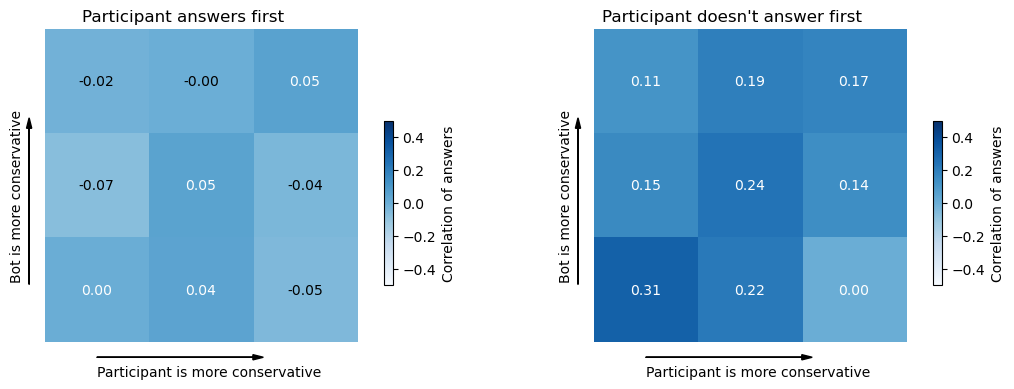

In [44]:
n = 3
corr_matrixes = [np.zeros((n, n)), np.zeros((n, n))]
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)

data_first = df_pair.loc[(df_pair['experiment'] != "condition_1") & (df_pair['who_answers_first'] == 1) & (~df_pair['ideology_all_zeros'])]
data_not_first = df_pair.loc[(df_pair['experiment'] == "condition_2") & (df_pair['who_answers_first'] != 1) & (~df_pair['ideology_all_zeros'])]
data_first['participant_ideology_group'], _ = split_pd_series(data_first["ideology"], n=n, split_method="rank")
data_not_first['participant_ideology_group'], _ = split_pd_series(data_not_first["ideology"], n=n, split_method="rank")

for participant_ideology_group in range(n):
    data_first_grouped = data_first.loc[data_first['participant_ideology_group'] == participant_ideology_group]
    data_not_first_grouped = data_not_first.loc[data_not_first['participant_ideology_group'] == participant_ideology_group]
    data_first_grouped['bot_ideology_group'], _ = split_pd_series(data_first_grouped['bot_ideology'], n=n, split_method="rank")
    data_not_first_grouped['bot_ideology_group'], _ = split_pd_series(data_not_first_grouped['bot_ideology'], n=n, split_method="rank")

    for bot_ideology_group in (range(n)):
        data_first_both_grouped = data_first_grouped.loc[data_first_grouped['bot_ideology_group'] == bot_ideology_group]
        data_not_first_both_grouped = data_not_first_grouped.loc[data_not_first_grouped['bot_ideology_group'] == bot_ideology_group]
        
        corr_matrixes[0][participant_ideology_group][n - 1 - bot_ideology_group] = pearsonr(data_first_both_grouped['answer'], data_first_both_grouped['bot_answer'])[0]
        corr_matrixes[1][participant_ideology_group][n - 1 - bot_ideology_group] = pearsonr(data_not_first_both_grouped['answer'], data_not_first_both_grouped['bot_answer'])[0]
        
        t, p = scipy.stats.ttest_ind(data_not_first_both_grouped['answer'], data_first_both_grouped['answer'])
        print(f"For human of ideology group {participant_ideology_group} and bot of group {bot_ideology_group}: ", end="")
        if p < 0.05 and t > 0:
            print(f"The mean opinion of human when he answers first is significantly greater than that when he doesn't, p={p:.2f}")
        elif p < 0.05 and t < 0:
            print(f"The mean opinion of human when he answers first is significantly smaller than that when he doesn't, p={p:.2f}")
        else:
            print(f"The mean opinions of human whether he answers first or not show no significant difference, p={p:.2f}")

for ax_idx in range(2):
    ax = axes[ax_idx]
    cax = ax.imshow(corr_matrixes[ax_idx].T, cmap="Blues", vmin=-0.5, vmax=0.5)
    cbar = fig.colorbar(cax, label="Correlation of answers", fraction=0.015)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{corr_matrixes[ax_idx][j, i]:.2f}", ha='center', va='center', color='black' if corr_matrixes[ax_idx][j, i] < 0.5 * (-0.5 + 0.5) else 'white')
    arrow_length = 1.5
    ax.arrow(0, 2.65, arrow_length, 0, head_width=0.05, head_length=0.1, fc='black', ec='black')
    ax.annotate("Participant is more conservative", xy=(0, 2.83))
    ax.arrow(-0.65, 1.95, 0, -arrow_length, head_width=0.05, head_length=0.1, fc='black', ec='black')
    ax.annotate("Bot is more conservative", xy=(-0.83, 1.9), rotation=90)
    for spine in ax.spines.values():
        spine.set_visible(False)
    if ax_idx == 0:
        ax.set(title="Participant answers first")
    else:
        ax.set(title="Participant doesn't answer first")

savefig(fig, f"visualization/{get_datetime_str()}-correlation-answers_first_or_not.pdf")